# RNNs: How To Implement A Basic RNN

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read In, Clean, And Split The Data

In [3]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LinkedIn Learning/03_Advanced NLP with Python for Machine Learning/Ex_Files_Adv_NLP_Python_ML/Exercise Files/data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0) # setting 1 for spam, remaining as 0

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

### Prep Data For Modeling

In [4]:
# Install keras
!pip install -U keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 2.15.0 which is incompatible.


In [5]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [7]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [8]:
# What do these sequences look like?
X_train_seq[0]

[1, 237, 2, 38, 3849, 2565, 28, 35, 83, 8, 68]

In [9]:
# Standardize the length of the sequences

# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [10]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    1,  237,    2,   38, 3849,
       2565,   28,   35,   83,    8,   68], dtype=int32)

### Build Model

In [11]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [12]:
# Construct a simple RNN model
model = Sequential()

# here we define total words there using the len() + 1, and out put as 32
model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          255584    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 264993 (1.01 MB)
Trainable params: 264993 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [14]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train,
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 34s 146ms/step - loss: 0.2797 - accuracy: 0.9069 - precision_m: 0.4438 - recall_m: 0.3479 - val_loss: 0.0520 - val_accuracy: 0.9874 - val_precision_m: 0.9524 - val_recall_m: 0.9483
Epoch 2/10
140/140 [==============================] - 7s 47ms/step - loss: 0.0350 - accuracy: 0.9910 - precision_m: 0.9521 - recall_m: 0.9223 - val_loss: 0.0338 - val_accuracy: 0.9901 - val_precision_m: 0.9895 - val_recall_m: 0.9436
Epoch 3/10
140/140 [==============================] - 3s 22ms/step - loss: 0.0174 - accuracy: 0.9955 - precision_m: 0.9840 - recall_m: 0.9684 - val_loss: 0.0254 - val_accuracy: 0.9919 - val_precision_m: 1.0000 - val_recall_m: 0.9412
Epoch 4/10
140/140 [==============================] - 3s 24ms/step - loss: 0.0068 - accuracy: 0.9982 - precision_m: 0.9917 - recall_m: 0.9813 - val_loss: 0.0201 - val_accuracy: 0.9919 - val_precision_m: 0.9895 - val_recall_m: 0.9540
Epoch 5/10
140/140 [==============================] - 4s 31ms/step

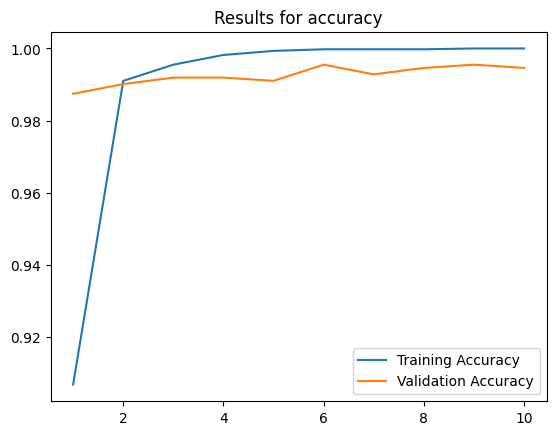

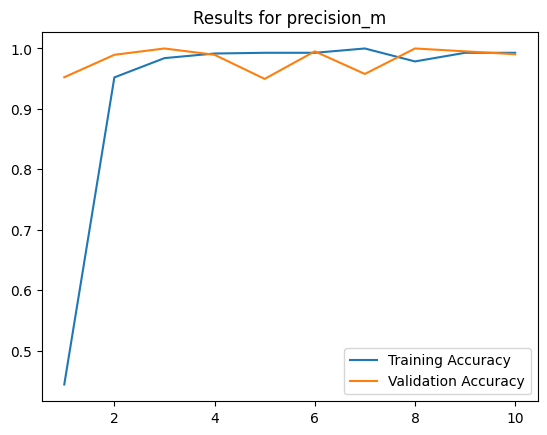

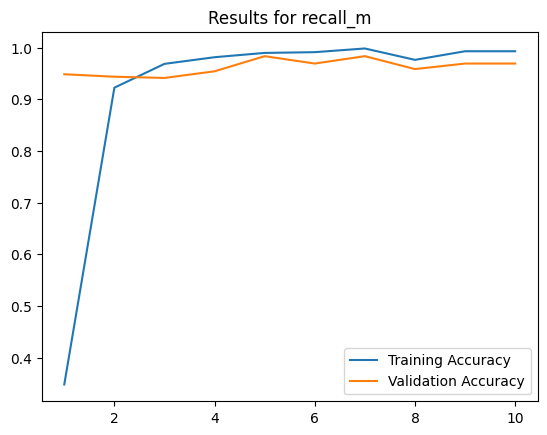

In [15]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()